<ipython-input-1-41117d9e5fdc>:57: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return cov(x_s, x_d).dot(np.linalg.lstsq(cov(x_d, x_d), y_d.T)[0]).reshape(-1, 1) + \
<ipython-input-1-41117d9e5fdc>:59: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  cov(x_s, x_d).dot(np.linalg.lstsq(cov(x_d, x_d), cov(x_d, x_s))[0]))\


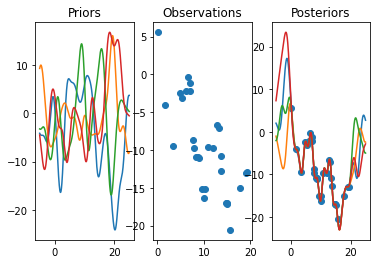

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def oracle_sampler(x, noise=False):
    """
    Random function
    if noise==True, add small random noise
    """
    y = - x + 2 * np.sin(3 * x) + 5 * np.cos(x)
    if noise:
        y += + 2 * np.random.randn(1, len(x))

    return y


def cov(x1, x2, cov_type='SE'):
    '''
    Gaussian Process covariance type
    '''
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(1, -1)

    if cov_type == 'SE':
        # Squared exponential covariance function
        covariance = np.exp(-0.5 * abs(x1 - x2)**2)
    else:
        raise NotImplementedError('Covariance type not recognized')

    return covariance


def gpr(x_s, x_d=None, y_d=None):
    """
    Given, 1xN input x
           1xN output y

    Given data, we can compute the value using
    \f[
    f_* | X_*, X, f \sim \mathcal{N}(K(X_*, X) K(X, X)^{-1} f,
      K(X_*, X_*) - K(X_*, X) K(X, X)^{-1} K(X, X_*))
    \f]

    returns n-dim kernel regression
    """
    n_x_s = len(x_s)
    if x_d is not None:
        n_x_d = len(x_d)
    else:
        n_x_d = 0

    n_x = n_x_s + n_x_d

    # For random samples from :math:`N(\mu, \sigma^2)`, use:
    #   sigma * np.random.randn(...) + mu
    if x_d is not None:
        return cov(x_s, x_d).dot(np.linalg.lstsq(cov(x_d, x_d), y_d.T)[0]).reshape(-1, 1) + \
            (cov(x_s, x_s) -
             cov(x_s, x_d).dot(np.linalg.lstsq(cov(x_d, x_d), cov(x_d, x_s))[0]))\
            .dot(np.random.randn(n_x_s, 1))
    else:
        return np.dot(cov(x_s, x_s), np.random.randn(n_x, 1))


if __name__ == "__main__":
    N_prior_sample = 4
    N_observation = 30
    N_posterior_sample = 4

    # Sample a random function from the GP prior.
    x_gp = np.linspace(-5, 25, 1000)
    x_observation = 20 * np.sort(np.random.rand(N_observation))
    y_prior = []
    for k in range(N_prior_sample):
        y_prior.append(gpr(x_gp))  # GP prior with 0 mean and unit variance.

    # Sample from the oracle.
    y_observation = oracle_sampler(x_observation)

    # Given $N$ observations, find the function that fits the GP function best
    y_posterior = []
    for k in range(N_posterior_sample):
        y_posterior.append(gpr(x_gp, x_observation, y_observation))

    fig, axarr = plt.subplots(1, 3)

    # Plot Priors
    axarr[0].set_title('Priors')
    for k in range(N_prior_sample):
        axarr[0].plot(x_gp, y_prior[k])

    # Plot the observations
    axarr[1].set_title('Observations')
    axarr[1].scatter(x_observation, y_observation)

    # Plot the sampled functions from the Gaussian Process
    axarr[2].set_title('Posteriors')
    axarr[2].scatter(x_observation, y_observation)
    for k in range(N_posterior_sample):
        axarr[2].plot(x_gp, y_posterior[k])

    plt.show()